# Лабораторна робота 4

## Завдання 

### 1. Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

### 2.Проведіть експерименти з моделями бібліотеки HF Transformers (https://huggingface.co/) за допомогою (наприклад) Pipeline модуля


### 3.Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [1]:
#1) Переклад тексту на основі RNN

In [2]:
import numpy as np
import string
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
def read_text(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

def to_lines(text):
    sents = text.strip().split('\n')
    return sents

text_eng_ukr=read_text('ukr.txt')
data_eng_ukr=to_lines(text_eng_ukr)#splitting into lines

In [83]:
df = pd.DataFrame()

df['eng'] = [line.split("\t")[0] for line in data_eng_ukr]
df['ukr'] = [line.split("\t")[1] for line in data_eng_ukr]

In [84]:
df.head()

,eng,ukr
0,Go.,Йди.
1,Hi.,Вітаю!
2,Hi.,Привіт.
3,Hi.,Привіт!
4,Run!,Біжіть!


In [85]:
#conver to lower and removing punctutations from dataframe
df["ukr"]=df["ukr"].str.lower().replace('[{}]'.format(string.punctuation), '')
df["eng"]=df["eng"].str.lower().replace('[{}]'.format(string.punctuation), '')

In [86]:
df.head()

,eng,ukr
0,go.,йди.
1,hi.,вітаю!
2,hi.,привіт.
3,hi.,привіт!
4,run!,біжіть!


In [87]:
df = df[:5000]#.sample(5000, random_state = 10)#select random 10000 row to train model faster

In [88]:
# prepare english tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df["eng"])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_seq = eng_tokenizer.texts_to_sequences(df["eng"])
eng_length = 8

eng_seq = pad_sequences(eng_seq, maxlen=eng_length, padding='post')
print('Size of English Vocabulary : %d' % eng_vocab_size)

# prepare uk tokenizer
ukr_tokenizer = Tokenizer()
ukr_tokenizer.fit_on_texts(df["ukr"])
ukr_vocab_size = len(ukr_tokenizer.word_index) + 1
ukr_seq = ukr_tokenizer.texts_to_sequences(df["ukr"])
ukr_length = 8
ukr_seq = pad_sequences(ukr_seq, maxlen=ukr_length, padding='post')

print('Size of Ukraine Vocabulary : %d' % ukr_vocab_size)

Size of English Vocabulary : 1161
Size of Ukraine Vocabulary : 2837


In [89]:
model = Sequential()
model.add(Embedding(eng_vocab_size, 256, input_length=eng_length, mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(ukr_length))
model.add(LSTM(256, return_sequences=True))
model.add(Dense(ukr_vocab_size, activation='softmax'))
 
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [90]:
model.fit(eng_seq, ukr_seq, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 10s 55ms/step - loss: 2.9030 - accuracy: 0.7082 - val_loss: 2.2977 - val_accuracy: 0.6960
Epoch 2/100
125/125 [==============================] - 6s 49ms/step - loss: 1.9296 - accuracy: 0.7470 - val_loss: 2.1310 - val_accuracy: 0.6965
Epoch 3/100
125/125 [==============================] - 6s 46ms/step - loss: 1.8645 - accuracy: 0.7487 - val_loss: 2.0853 - val_accuracy: 0.6980
Epoch 4/100
125/125 [==============================] - 5s 38ms/step - loss: 1.8388 - accuracy: 0.7488 - val_loss: 2.0841 - val_accuracy: 0.6980
Epoch 5/100
125/125 [==============================] - 6s 44ms/step - loss: 1.8174 - accuracy: 0.7490 - val_loss: 2.0708 - val_accuracy: 0.6981
Epoch 6/100
125/125 [==============================] - 6s 48ms/step - loss: 1.8009 - accuracy: 0.7492 - val_loss: 2.0586 - val_accuracy: 0.6984
Epoch 7/100
125/125 [==============================] - 5s 42ms/step - loss: 1.7845 - accuracy: 0.7494 - val_loss: 2.0661 - val_accuracy

In [99]:
y_id_to_word = {value: key for key, value in ukr_tokenizer.word_index.items()}
y_id_to_word[0] = ""

sentences = ['i like this','i have a new work','i can win']
for sentence in sentences:
    sentence = [eng_tokenizer.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=eng_seq.shape[-1], padding='post')
    predictions = model.predict(sentence)
    print(' '.join([y_id_to_word[np.argmax(pred)] for pred in predictions[0]]))

1/1 [==============================] - 0s 21ms/step
мені це подобається     
1/1 [==============================] - 0s 24ms/step
я мене рацію     
1/1 [==============================] - 0s 10ms/step
я можу виграти     


In [3]:
# 2)  експерименти з моделями бібліотеки HF Transformers 

# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="m3hrdadfi/zabanshenas-roberta-base-mix")#Модель визначає мову, якою написаний текст

config.json:   0%|          | 0.00/8.58k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/545k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/331k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/943k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [4]:
pipe("Цифрові двійники — це віртуальні представлення фізичних об’єктів або систем. Ці уявлення дозволяють нам контролювати цифрового двійника під впливом зовнішніх/внутрішніх змінних і прогнозувати, як він працюватиме у виробничому середовищі.Одне з найскладніших механічних середовищ можна знайти при високій температурі та високому тиску, наприклад, у геотермальній енергетиці. Як критичний компонент переходу до чистіших відновлюваних джерел енергії, пошук більш ефективних методів використання життєздатних термальних резервуарів є важливим. У міру того, як свердла проникають глибше в землю, тиск і температура висуває бурове обладнання на межі своїх можливостей, і швидкість проходки (ROP) може знизитися до менш ніж кількох футів на хвилину. У цьому підручнику ми будемо використовувати Digital Twin AI Reference Kit для створення цифрового близнюка для геотермальної бурової установки для моделювання впливу на ROP маніпулювання чотирма параметрами керування бурінням: вага на долоті (WOB), швидкість обертання (RPM), потік швидкість (FLOW) і крутний момент (TOR).")

[{'label': 'ukr', 'score': 0.997283935546875}]

In [5]:
pipe("Use a pipeline as a high-level helper")

[{'label': 'eng', 'score': 0.37577658891677856}]

In [6]:
#3) Генерація зображень VAE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('image shape', x_train[0].shape)

4422102/4422102 [==============================] - 2s 0us/step
60000 train samples
10000 test samples
image shape (28, 28)


In [8]:
original_dim = 28 * 28 #784

x_train = x_train.reshape(60000, original_dim)
x_test = x_test.reshape(10000, original_dim)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
# reparameterization trick
# z = z_mean + sqrt(var) * epsilon, epsilon = N(0,I)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [10]:
def build_encoder():
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return

In [23]:
def plot_results(encoder, decoder, x_test, y_test, batch_size=128):

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample,verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

In [24]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [14]:
# VAE model = encoder + decoder
# build encoder model
inputs = keras.Input(shape=input_shape, name='encoder_input')
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# instantiate encoder model
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense_1[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense_1[0][0]']             
                                                                                            

In [15]:
# build decoder model
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
# instantiate decoder model
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 512)               1536      
                                                                 
 dense_3 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs)
reconstruction_loss = keras.losses.binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  403972    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  403728    ['encoder[1][2]']             
                                                                                            

In [18]:
vae.fit(x_train,  epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
469/469 [==============================] - 6s 11ms/step - loss: 306.1621 - val_loss: 282.3863
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 278.3690 - val_loss: 277.7076
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 274.0857 - val_loss: 273.6328
Epoch 4/50
469/469 [==============================] - 5s 12ms/step - loss: 271.7024 - val_loss: 271.7068
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 270.1351 - val_loss: 270.2772
Epoch 6/50
469/469 [==============================] - 6s 12ms/step - loss: 268.9077 - val_loss: 269.8300
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 268.0312 - val_loss: 268.5495
Epoch 8/50
469/469 [==============================] - 7s 15ms/step - loss: 267.0653 - val_loss: 267.8705
Epoch 9/50
469/469 [==============================] - 6s 13ms/step - loss: 266.2468 - val_loss: 267.1260
Epoch 10/50
469/469 [==============================] - 

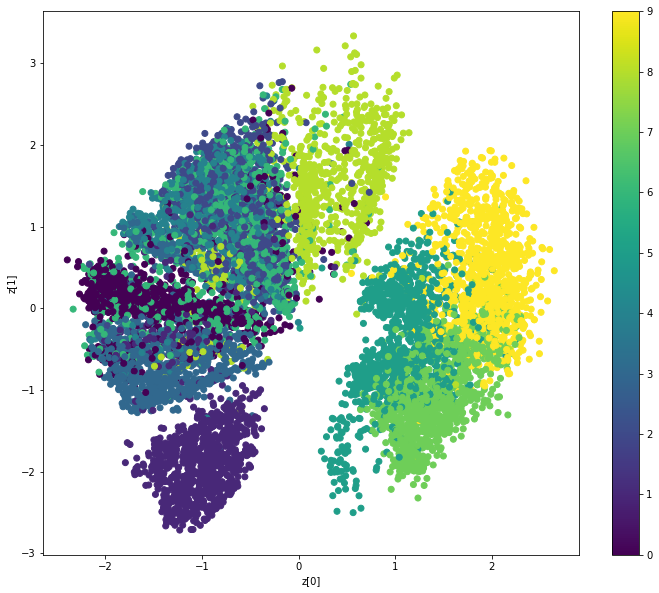

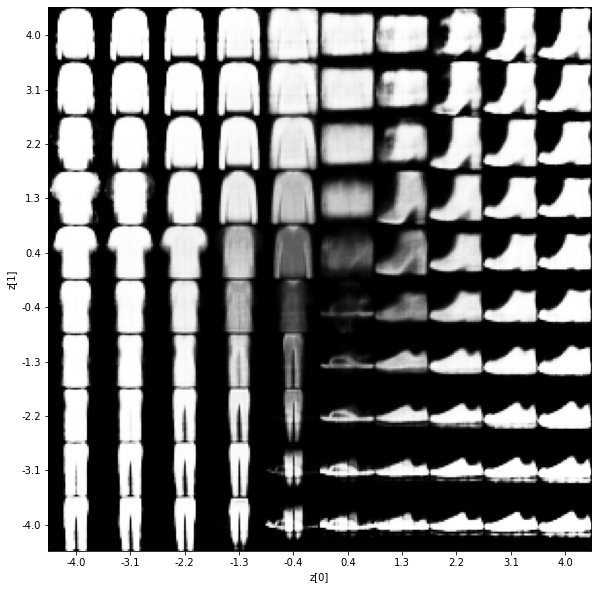

In [25]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)